In [1]:
import pandas as pd
import pyarrow
import datetime as dt
import numpy as np

Считываем датасеты. В этом задании я решила обратить внимание на два датасета:  𝑡𝑟𝑎𝑛𝑠𝑎𝑐𝑡𝑖𝑜𝑛𝑠  и  𝑐𝑙𝑖𝑒𝑛𝑡𝑠 . В датасете  𝑐𝑙𝑖𝑒𝑛𝑡𝑠  мы видим, что у нас достаточно маленькая выборка клиентов -10к, также из датасета  𝑡𝑟𝑎𝑛𝑠𝑎𝑐𝑡𝑖𝑜𝑛𝑠  мы видим, что данные даны за год. Исходя из этих двух пунктов я решила не прекручивать фич из двух других датасетов, иначе модель может переобучиться

In [2]:
df_transactions = pd.read_parquet('transactions.parquet')

In [3]:
df_clients = pd.read_csv('clients.csv')

In [4]:
df_trans = df_transactions.sort_values(by=['client_id', 'chq_date'])

In [5]:
df_trans['client_id'] = df_trans['client_id'].astype(str) 

Мы хотим узнать, как долго клиент пользовался сервисом. Поэтому строим датасет $df2$. Также сколько покупок он совершил за всё это время $df3$. Потом соединяем их в единый  датасет и объедиям с $df clients$

In [6]:
df2 = df_trans.groupby(['client_id']).agg({'chq_date':['min','max']})

In [7]:
df2.columns = df2.columns.map(''.join)
df2['total_service_lenghth'] = df2.chq_datemax - df2.chq_datemin
df2['total_service_lenghth'] = pd.to_numeric(df2['total_service_lenghth'].dt.days, downcast='integer')
df2 = df2.rename(columns={"chq_datemax": "check_last_date", "chq_datemin": "check_first_date"})
df2.reset_index(drop=False, inplace=True)

In [8]:
df3 = df_trans.groupby(['client_id'])['chq_id'].nunique().to_frame()
df3.columns = df3.columns.map(''.join)
df3.reset_index(drop=False, inplace=True)

In [9]:
res = pd.merge(df2, df3, on= ['client_id'])
res = res.rename(columns={"chq_id":'total_amount_of_purchases'})

In [10]:
full_clients_df = pd.merge(df_clients, res , on=['client_id'])

Выбросим колонки $gender$ и $birthyear$ за ненадобностью.

In [11]:
full_clients_df = full_clients_df.drop(['gender', 'birthyear'], axis=1)

In [12]:
full_clients_df 

,client_id,city,check_first_date,check_last_date,total_service_lenghth,total_amount_of_purchases
0,1a47d62dddacc03fe90c15652f7ae1a4,Other,2016-10-08,2017-09-30,357,15
1,9cb909f701d25d548e953bff81192b56,Other,2016-10-28,2017-08-15,291,18
2,d5da0f5b841b4f83383202807995027a,Other,2016-10-16,2017-09-18,337,6
3,13ed7f16810b17b8cee6de834ac79a48,Moscow,2016-10-28,2017-08-31,307,5
4,215fe3ea7d5bf0415e5504e2a7f33551,Other,2016-10-07,2017-08-25,322,59
...,...,...,...,...,...,...
99990,9e7e66fc2c2dcfd8977bc0cffeff8eb5,Other,2016-10-11,2017-10-01,355,61
99991,e261c97d40ab839926c712b4aa6cefd8,St. Petersburg,2016-11-01,2017-07-20,261,14
99992,678ef46f41f8c89f7e8578c9e9592e3e,Other,2016-12-02,2017-02-12,72,7
99993,274facf0609ceba803f5853bd2222208,Other,2016-10-30,2017-02-12,105,5


In [13]:
full_clients_df['days_from_last_chq'] = df_trans.chq_date.max() - full_clients_df.check_last_date
full_clients_df['days_from_last_chq'] = pd.to_numeric(full_clients_df['days_from_last_chq'] .dt.days, downcast='integer')


In [14]:
full_clients_df['purchase_density'] = full_clients_df['total_amount_of_purchases'] / (full_clients_df['total_service_lenghth']+1)
full_clients_df


,client_id,city,check_first_date,check_last_date,total_service_lenghth,total_amount_of_purchases,days_from_last_chq,purchase_density
0,1a47d62dddacc03fe90c15652f7ae1a4,Other,2016-10-08,2017-09-30,357,15,4,0.041899
1,9cb909f701d25d548e953bff81192b56,Other,2016-10-28,2017-08-15,291,18,50,0.061644
2,d5da0f5b841b4f83383202807995027a,Other,2016-10-16,2017-09-18,337,6,16,0.017751
3,13ed7f16810b17b8cee6de834ac79a48,Moscow,2016-10-28,2017-08-31,307,5,34,0.016234
4,215fe3ea7d5bf0415e5504e2a7f33551,Other,2016-10-07,2017-08-25,322,59,40,0.182663
...,...,...,...,...,...,...,...,...
99990,9e7e66fc2c2dcfd8977bc0cffeff8eb5,Other,2016-10-11,2017-10-01,355,61,3,0.171348
99991,e261c97d40ab839926c712b4aa6cefd8,St. Petersburg,2016-11-01,2017-07-20,261,14,76,0.053435
99992,678ef46f41f8c89f7e8578c9e9592e3e,Other,2016-12-02,2017-02-12,72,7,234,0.095890
99993,274facf0609ceba803f5853bd2222208,Other,2016-10-30,2017-02-12,105,5,234,0.047170


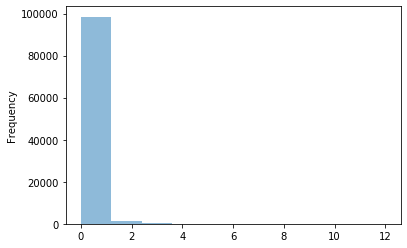

In [16]:
full_clients_df.purchase_density.plot.hist(alpha=0.5, bins=10)

In [19]:
full_clients_df.purchase_density.max(), len(full_clients_df[full_clients_df.purchase_density >1])

(12.0, 1540)

Из гистограммы сверху мы видим, что в основном значения в $purchase density$ вариьируются от $0$ до $1$. Но есть значения и больше $1$. Таких клиентов не много и  их нельзя считать постоянными. За год они были в магазине всего пару раз и совершали большие покупки (длинные чеки). Скорее всего они забегали перед праздниками. Так как их мало, и частота их появления мала мы выкидываем их

In [21]:
full_result_clients_cut = full_clients_df[(full_clients_df.purchase_density <=1) ]

In [25]:
df_trans['week'] = df_trans.chq_date.dt.to_period(freq="W")

In [592]:
clients_cut = full_result_clients_cut.client_id.values
df_trans_cut = df_trans[df_trans.client_id.isin(clients_cut)]

Чтобы выявить отточных клиентов, мы будем сравнивать их финансовое поведение. Мы разобьем год на недели, и посчитаем сумму покупок в неделю. Дальше мы будем брать определенный период - 8 недель. Для восьми недель у нас будет восемь сумм.  Будем польщоваться статистическими тестами чтобы сравнить поведение клиентов. 

Сразу обговорю несколлько допущений. 


1) за рефересный период мы берем первые два месяца - это октябрь и ноябрь. Предполагается, что эти месяцы могут давать представление об усредненном поведении клиентов. В них нет крупных праздников, каникул итд. Те поведение клиента будет стандартным "работа - лента -дом"

2) статистические тесты сравнивают похожесть двух выборок, но не указывают на то, упала ли активность клиента по сравнению с тестовой выборкой или возросла. Для индикации этого процесса мы введем специальный коэффициент, который будет принимать значение -1 если активность падает, и +1 если возрастает. Pvalue будет умножаться на данный коэффициент.

3) Мы составим два датасета, чтобы проанализировать поведение клиента с разных точек зрения. Мы сравним их по отдельности и объединим.  В первом датасете мы будем сравнивать финансовое поведение клиента. Во-втором, просто заходил клиент в магазин или нет (количество заходов в неделю.

4) В первом случае мы просумммируем траты на каждой недее в году, разобьем их на выборке в два месяца и будет прогонять тест Крускала-Уолисса для получения pvalue.   По этому значению можно судить, походи выборки, или нет. Для подсчета коэффициента мы будем сравнивать медиану и среднее сумм покупок, если мы види что эти показатели не меняются сильно или растут, мы умножаем на +1. В случае, если же эти показатели падают по сравнению с реверенсом - умножаем на -1.

5) Во втором случае мы будем сравнивать численную активность клиента - количеество заходов на неделе. ТЕст остается тем же - Крускалл Уоллис. Для подсчета коэффициентов мы будем сравнивать, возрастает ли количество недель, что клиент не заходит в магазин или падает. Если падаеет - умножаем на +1,  если возрастает - -1.

6) Если выборка которая сравнивается с референсной полностью состоит из нулей (для обоих случаев) мы приравниваем результрующее pvalue к -1.

7) Тест Крускалла_Уоллиса был выбран мною по следующим соображениям: 1) он непарметрический и может применяться для выборок, чье распределение мы изначально не знаем 2) он работает с ранками, а не с самими значениями - следовательно, он устойчив к выбросам.

8) Модели нельзя давать данные за весь период, потому что модель сразу различит постоянного клиента, от того, который ушел. Я буду выделять предполагаемы период ухода - 2 месяца и брать четыре месяца до этого ухода. Для всех этих данных я посчитаю численные характеристики (о них ниже) еще раз отсею тех кто ушел от тех кто не ушел и раздам классы.

Здесь и далее пойдет полотно кода, который следовало бы обернуть в функции. Я сразу прошу прощения, что не сделала это


Здесь я буду готовить два датасета 'df_result_chqs.csv' и 'df_result_sums.csv'.   Для начала я посчитаю сумму покупок для 'df_result_sums.csv' и количество заходов для 'df_result_chqs.csv' по неделям. Потом прогоню стат тест Крускалла-Уолиса, домножая это на коэффициент. Тк у нас в случае пустых недель для обоих датасетов будет выдаваться -1 как pvalue* coeff я сравню медианы полученных 6  pvalue с единицей. Что значит  pvalue* coeff== -1? -значит в выборке, которую я сравниваю с референсной, из 2 месяцев, все недели  пустые - те клиент не заходил в магазин. Что значит медиана полученных значений равна -1 (или около того) ? значит было больше 3 выборок, в которых все недели пустые. Эти клиенты представляют собой выборку из очень разряженных по поведению покуппателей, часто встречается такая картина, что клиент был в магазине меньше 10 раз за год. Это не репрезентативный клиент и мы не можем анализировать его поведение. Мы выкидываем таких клиентов. Для оставшихся будем считать следующие характеристики:

В качестве фич я взяла численные характеристики, которые по моему мнению, отражют поведение клиента:

Период =4 месяца до предполагаемого ухода

1) total_num_chqs - количество покупок за наблюдаемый период

2) total_num_days - количество раз заходов в магазин (например чек если мы заходили два раза в 23/12/20 то мы считаем за один раз6 по количеству уникальных дат)

3) num_unique_goods - сколько всего было куплено уникальных продуктов за весь период

4) total_money_spent - сколько денег потрачено за весь период

5) total_is_promo_sum - сколько денег потрачено за весь период на акционные товары

6) trend_coef очень игрушечная фича, и если честно я в ней сомневаюсь. Она представляет собой разность суммы  \заходов в первый и последний месяц, деленное на среднее за весь период (в результирующем датасете я выкину эту х-ку, тк неразумно брать среднее от сумм и заходов в магазин.

7) sparsity - количество пустых недель (без транзакций) деленное на 16

При получении колонки  sparsity  мы еще раз проверим верно ли наше разделение - 
Если значение sparsity <0.2 значит поведение клиента плотное и мы не можем говорить о его уходе
если sparsity>0.8  то клиент вряд ли задержался

In [601]:
week_sums= df_trans_cut.groupby(['client_id', 'week'])['chq_date'].count().to_frame()
week_sums.reset_index(drop=False, inplace=True)
week_sums.week= week_sums.week.astype(str)
weeks = pd.get_dummies(week_sums.week)
weeks = weeks.rename(columns= {'2016-10-03/2016-10-09' : '01', '2016-10-10/2016-10-16'  : '02',
             '2016-10-17/2016-10-23' : '03', '2016-10-24/2016-10-30' : '04',
             '2016-10-31/2016-11-06' : '05', '2016-11-07/2016-11-13' : '06',
             '2016-11-14/2016-11-20' : '07', '2016-11-21/2016-11-27' : '08',
             '2016-11-28/2016-12-04' : '09', '2016-12-05/2016-12-11' : '10',
             '2016-12-12/2016-12-18' : '11', '2016-12-19/2016-12-25' : '12',
             '2016-12-26/2017-01-01' : '13', '2017-01-02/2017-01-08' : '14',
             '2017-01-09/2017-01-15' : '15', '2017-01-16/2017-01-22' : '16',
             '2017-01-23/2017-01-29' : '17', '2017-01-30/2017-02-05' : '18',
             '2017-02-06/2017-02-12' : '19', '2017-02-13/2017-02-19' : '20',
             '2017-02-20/2017-02-26' : '21', '2017-02-27/2017-03-05' : '22',
             '2017-03-06/2017-03-12' : '23', '2017-03-13/2017-03-19' : '24',
             '2017-03-20/2017-03-26' : '25', '2017-03-27/2017-04-02' : '26',
             '2017-04-03/2017-04-09' : '27', '2017-04-10/2017-04-16' : '28',
             '2017-04-17/2017-04-23' : '29', '2017-04-24/2017-04-30' : '30',
             '2017-05-01/2017-05-07' : '31', '2017-05-08/2017-05-14' : '32',
             '2017-05-15/2017-05-21' : '33', '2017-05-22/2017-05-28' : '34',
             '2017-05-29/2017-06-04' : '35', '2017-06-05/2017-06-11' : '36',
             '2017-06-12/2017-06-18' : '37', '2017-06-19/2017-06-25' : '38',
             '2017-06-26/2017-07-02' : '39', '2017-07-03/2017-07-09' : '40',
             '2017-07-10/2017-07-16' : '41', '2017-07-17/2017-07-23' : '42',
             '2017-07-24/2017-07-30' : '43', '2017-07-31/2017-08-06' : '44',
             '2017-08-07/2017-08-13' : '45', '2017-08-14/2017-08-20' : '46',
             '2017-08-21/2017-08-27' : '47', '2017-08-28/2017-09-03' : '48',
             '2017-09-04/2017-09-10' : '49', '2017-09-11/2017-09-17' : '50',
             '2017-09-18/2017-09-24' : '51', '2017-09-25/2017-10-01' : '52',
             '2017-10-02/2017-10-08' : '53'})

weeks =weeks.astype(int)

In [175]:
week_sums2= df_trans_cut.groupby(['client_id', 'week'])['sales_sum'].sum().to_frame()
week_sums2.reset_index(drop=False, inplace=True)
week_sums_dummies2 = pd.merge(week_sums2, weeks, on= weeks.index)
week_sums_dummies2 =  week_sums_dummies2.drop(['week'], axis=1)
week_sums_dummies2 =  week_sums_dummies2.drop(['key_0'], axis=1)

In [176]:
week_sums2

,client_id,week,sales_sum
0,0000d48a8891cd462fdf01ea861ec53e,2016-10-31/2016-11-06,1655.0
1,0000d48a8891cd462fdf01ea861ec53e,2016-11-14/2016-11-20,2475.0
2,0000d48a8891cd462fdf01ea861ec53e,2016-11-28/2016-12-04,4481.0
3,0000d48a8891cd462fdf01ea861ec53e,2016-12-05/2016-12-11,2030.0
4,0000d48a8891cd462fdf01ea861ec53e,2016-12-12/2016-12-18,1502.0
...,...,...,...
1698108,fffc477269ae5f219e39aa51fa7abb81,2017-05-08/2017-05-14,3882.0
1698109,fffc477269ae5f219e39aa51fa7abb81,2017-06-19/2017-06-25,6661.0
1698110,fffd3e78e3ea6bf00aee1372efc09dad,2016-10-10/2016-10-16,1213.0
1698111,fffd3e78e3ea6bf00aee1372efc09dad,2016-11-28/2016-12-04,220.0


In [178]:

for idx in weeks.columns.values:
     week_sums_dummies2[idx] =  week_sums_dummies2[idx] *  week_sums_dummies2['sales_sum']

In [182]:
week_sums_dummies2

,client_id,sales_sum,01,02,03,04,05,06,07,08,...,44,45,46,47,48,49,50,51,52,53
0,0000d48a8891cd462fdf01ea861ec53e,1655.0,0.0,0.0,0.0,0.0,1655.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000d48a8891cd462fdf01ea861ec53e,2475.0,0.0,0.0,0.0,0.0,0.0,0.0,2475.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0000d48a8891cd462fdf01ea861ec53e,4481.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0000d48a8891cd462fdf01ea861ec53e,2030.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0000d48a8891cd462fdf01ea861ec53e,1502.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698108,fffc477269ae5f219e39aa51fa7abb81,3882.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1698109,fffc477269ae5f219e39aa51fa7abb81,6661.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1698110,fffd3e78e3ea6bf00aee1372efc09dad,1213.0,0.0,1213.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1698111,fffd3e78e3ea6bf00aee1372efc09dad,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
week_clients_sums2 =  week_sums_dummies2.groupby('client_id')['01', 
        '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53'].sum()

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [181]:
week_clients_sums2.reset_index(drop=False, inplace=True)

In [183]:
week_clients_sums2

,client_id,01,02,03,04,05,06,07,08,09,...,44,45,46,47,48,49,50,51,52,53
0,0000d48a8891cd462fdf01ea861ec53e,0.0,0.0,0.0,0.0,1655.0,0.0,2475.0,0.0,4481.0,...,0.0,7596.0,0.0,0.0,2046.0,0.0,0.0,0.0,0.0,0.0
1,00028a1dcb30863404a386961a69300e,678.0,0.0,2450.0,0.0,1841.0,0.0,0.0,0.0,0.0,...,847.0,1569.0,0.0,1053.0,45.0,577.0,1205.0,0.0,0.0,0.0
2,0004274683494a9eca5e70ef97299d55,1175.0,1819.0,1085.0,527.0,538.0,1357.0,2239.0,792.0,3306.0,...,1137.0,667.0,1788.0,306.0,463.0,5067.0,3510.0,1151.0,0.0,5095.0
3,00072f81efcb3481861f7300c5e2a88a,0.0,0.0,0.0,571.0,0.0,0.0,299.0,192.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1812.0,0.0,0.0,0.0,0.0
4,00076596eb749cf10c2e984621dffe95,9225.0,1578.0,3624.0,1812.0,0.0,0.0,0.0,0.0,6252.0,...,5212.0,4193.0,7827.0,2915.0,1650.0,4044.0,2303.0,3659.0,2454.0,3351.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98450,fffb2f36eb72ff56d2ef7a2685714f01,2699.0,0.0,1719.0,640.0,4334.0,0.0,0.0,0.0,451.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2057.0,0.0,0.0,0.0
98451,fffb50df95231c0f090b5aa3f5332c7f,1416.0,0.0,39.0,463.0,182.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98452,fffc3f2be1422d248dbeda4196ef0711,0.0,116.0,773.0,0.0,0.0,0.0,543.0,1067.0,2939.0,...,1791.0,3682.0,0.0,0.0,0.0,0.0,0.0,964.0,0.0,0.0
98453,fffc477269ae5f219e39aa51fa7abb81,0.0,0.0,0.0,8009.0,0.0,8582.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
pvalues_dict_eight2 = {1: [],
               2 : [],
               3 : [],
               4 : [],
               5 : [],
               6 : [],
               }

In [278]:
# ind = 3000
for ind in range(98455):
    ref_data = week_clients_sums2.loc[ind][weeks.columns.values[0*8 : (0+1)*8]]
    ref_zers = ref_data.eq(0,axis =0 ).sum()
    ref_sum_ = ref_data.sum()
    ref_mean_ = ref_data.mean()
    ref_median_ = ref_data.median()
    ref_std_ = ref_data.std()
    ref_var_ = ref_data.var()

    for i in range(1,7):
        com_data = week_clients_sums2.loc[ind][weeks.columns.values[i*8 : (i+1)*8]]
#         print(com_data.values)
        coeff = -1
        if ref_median_ ==0 :
            if(com_data.mean() >=ref_mean_) | ( ref_mean_ / com_data.mean()<=5):
                    coeff = 1
        else:
            if com_data.median() == 0:
                if(com_data.mean() >=ref_mean_) | ( ref_mean_ / com_data.mean()<=5):
                    coeff = 1 
                coeff = -1
            else:
                if(com_data.median() >=ref_median_) | ( ref_median_ / com_data.median()<=3):
                    coeff = 1
#         print(com_data.sum(), com_data.mean(), com_data.median(),coeff)  
        sum_ = com_data.sum()
        if sum_ == 0:
            pvalues_dict_eight2[i].append(-1)
#         print(-1)
        else:
            pvalues_dict_eight2[i].append(scipy.stats.kruskal(ref_data,com_data).pvalue * coeff)
# #         pvalues_dict_eight[i].append(scipy.stats.kruskal(ref_data,com_data).pvalue * 
# #                                  ( 1 if ref_zers >= com_zers else (-1)))
#     com_zers = com_data.eq(0,axis =0 ).sum()
#     sum_ = com_data.sum()
#     if sum_ == 0:
# #         pvalues_dict_eight[i].append(-1)
#         print(-1)
#     else:
#         print(scipy.stats.kruskal(ref_data,com_data).pvalue * ( 1 if ref_zers >= com_zers else (-1)))
# #         pvalues_dict_eight[i].append(scipy.stats.kruskal(ref_data,com_data).pvalue * 
# #                                  ( 1 if ref_zers >= com_zers else (-1)))

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


In [279]:
pvalues_dataset_eight_sign_3 = pd.DataFrame.from_dict(pvalues_dict_eight2)

In [320]:
pvalues_clients_3 = pd.merge(week_clients_sums2[['client_id']], pvalues_dataset_eight_sign_3, 
                             on =week_clients_sums2.index )

In [358]:
pvalues_clients_3

,key_0,client_id,1,2,3,4,5,6
0,0,0000d48a8891cd462fdf01ea861ec53e,0.164915,0.062357,0.056517,0.001216,0.105193,-1.000000
1,1,00028a1dcb30863404a386961a69300e,0.701671,0.487453,0.951886,0.197035,0.510671,0.802311
2,2,0004274683494a9eca5e70ef97299d55,0.833635,0.074203,0.045999,0.004574,0.674424,0.241567
3,3,00072f81efcb3481861f7300c5e2a88a,-1.000000,0.300776,0.300776,0.609523,-1.000000,0.720652
4,4,00076596eb749cf10c2e984621dffe95,0.240955,0.112506,0.072077,0.019931,0.019931,0.074870
...,...,...,...,...,...,...,...,...
98450,98450,fffb2f36eb72ff56d2ef7a2685714f01,-0.643429,0.380455,-0.816961,-0.907869,-1.000000,-0.316620
98451,98451,fffb50df95231c0f090b5aa3f5332c7f,-0.643429,-0.125458,-0.816961,-0.201643,-1.000000,-1.000000
98452,98452,fffc3f2be1422d248dbeda4196ef0711,-0.907869,-0.334334,0.736468,0.025181,0.369493,-0.403986
98453,98453,fffc477269ae5f219e39aa51fa7abb81,-1.000000,-1.000000,1.000000,0.441125,-1.000000,-1.000000


In [360]:
pvalues_clients_3[pvalues_dataset_eight_sign_3.median(axis=1) >-0.9]

,key_0,client_id,1,2,3,4,5,6
0,0,0000d48a8891cd462fdf01ea861ec53e,0.164915,0.062357,0.056517,0.001216,0.105193,-1.000000
1,1,00028a1dcb30863404a386961a69300e,0.701671,0.487453,0.951886,0.197035,0.510671,0.802311
2,2,0004274683494a9eca5e70ef97299d55,0.833635,0.074203,0.045999,0.004574,0.674424,0.241567
3,3,00072f81efcb3481861f7300c5e2a88a,-1.000000,0.300776,0.300776,0.609523,-1.000000,0.720652
4,4,00076596eb749cf10c2e984621dffe95,0.240955,0.112506,0.072077,0.019931,0.019931,0.074870
...,...,...,...,...,...,...,...,...
98447,98447,fff9c0126292c7cc93ca9ce72f3829a5,0.061414,0.001476,0.034698,0.189956,0.927264,-1.000000
98449,98449,fffa0cff52ebf9897f1c1dd4fe608aa8,0.609523,-0.782595,0.537739,0.354539,0.890265,0.858100
98450,98450,fffb2f36eb72ff56d2ef7a2685714f01,-0.643429,0.380455,-0.816961,-0.907869,-1.000000,-0.316620
98451,98451,fffb50df95231c0f090b5aa3f5332c7f,-0.643429,-0.125458,-0.816961,-0.201643,-1.000000,-1.000000


In [361]:
pvalues_clients_3_cut = pvalues_clients_3[pvalues_dataset_eight_sign_3.median(axis=1) >-0.9]

In [395]:
pvalues_clients_3_cut = pvalues_clients_3_cut.drop(columns = ['key_0'])
pvalues_clients_3_cut

,client_id,1,2,3,4,5,6
0,0000d48a8891cd462fdf01ea861ec53e,0.164915,0.062357,0.056517,0.001216,0.105193,-1.000000
1,00028a1dcb30863404a386961a69300e,0.701671,0.487453,0.951886,0.197035,0.510671,0.802311
2,0004274683494a9eca5e70ef97299d55,0.833635,0.074203,0.045999,0.004574,0.674424,0.241567
3,00072f81efcb3481861f7300c5e2a88a,-1.000000,0.300776,0.300776,0.609523,-1.000000,0.720652
4,00076596eb749cf10c2e984621dffe95,0.240955,0.112506,0.072077,0.019931,0.019931,0.074870
...,...,...,...,...,...,...,...
98447,fff9c0126292c7cc93ca9ce72f3829a5,0.061414,0.001476,0.034698,0.189956,0.927264,-1.000000
98449,fffa0cff52ebf9897f1c1dd4fe608aa8,0.609523,-0.782595,0.537739,0.354539,0.890265,0.858100
98450,fffb2f36eb72ff56d2ef7a2685714f01,-0.643429,0.380455,-0.816961,-0.907869,-1.000000,-0.316620
98451,fffb50df95231c0f090b5aa3f5332c7f,-0.643429,-0.125458,-0.816961,-0.201643,-1.000000,-1.000000


In [398]:
pvalues_clients_3_cut['gone_5_6'] =(( pvalues_clients_3_cut[6]<0) & ( pvalues_clients_3_cut[5]<0)).astype(int)

In [402]:
pvalues_clients_3_cut = pvalues_clients_3_cut.rename(columns = {'gone_5_6': 'gone_11_13'})

In [415]:
pvalues_clients_3_cut['gone_9_10'] =((pvalues_clients_3_cut[4]<0) & ( pvalues_clients_3_cut[6]<0) & ( pvalues_clients_3_cut[5]<0)).astype(int)

In [417]:
pvalues_clients_3_cut['gone_7_8'] =(( pvalues_clients_3_cut[3] < 0)
                                    & ( pvalues_clients_3_cut[4]<0)
                                    & ( pvalues_clients_3_cut[6]<0)
                                    & ( pvalues_clients_3_cut[5]<0)).astype(int)

In [419]:
pvalues_clients_3_cut['gone_5_6'] =(  ( pvalues_clients_3_cut[2]<0)
                                    & ( pvalues_clients_3_cut[3]<0)
                                    & ( pvalues_clients_3_cut[4]<0)
                                    & ( pvalues_clients_3_cut[6]<0)
                                    & ( pvalues_clients_3_cut[5]<0)).astype(int)

In [423]:
pvalues_clients_3_cut['gone'] =( pvalues_clients_3_cut['gone_9_10'] |
                                pvalues_clients_3_cut['gone_11_13'] |
                                pvalues_clients_3_cut['gone_7_8'] |
                                pvalues_clients_3_cut['gone_5_6'] )

In [421]:
pvalues_clients_3_cut['gone_9_10'].sum(), pvalues_clients_3_cut['gone_11_13'].sum(), pvalues_clients_3_cut['gone_7_8'].sum(), pvalues_clients_3_cut['gone_5_6'].sum()

(12155, 23627, 6844, 5095)

In [ ]:
pvalues_clients_3_cut = pvalues_clients_3_cut[[ 'client_id',     
                                               1,   2,   3,  4,  5,  6, 
                                               'gone_5_6', 'gone_7_8', 'gone_9_10', 'gone_11_13', 
                                               'gone']]

In [425]:
clients_cut = pvalues_clients_3_cut.client_id.values

In [426]:
df_trans_cut = df_trans[df_trans.client_id.isin(clients_cut)]

In [428]:
df_trans_cut['week_encoded'] = df_trans_cut['week'].astype(str)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [430]:
df_trans_cut['week_encoded'] =  df_trans_cut.week_encoded.replace( {'2016-10-03/2016-10-09' : '01', '2016-10-10/2016-10-16'  : '02',
             '2016-10-17/2016-10-23' : '03', '2016-10-24/2016-10-30' : '04',
             '2016-10-31/2016-11-06' : '05', '2016-11-07/2016-11-13' : '06',
             '2016-11-14/2016-11-20' : '07', '2016-11-21/2016-11-27' : '08',
             '2016-11-28/2016-12-04' : '09', '2016-12-05/2016-12-11' : '10',
             '2016-12-12/2016-12-18' : '11', '2016-12-19/2016-12-25' : '12',
             '2016-12-26/2017-01-01' : '13', '2017-01-02/2017-01-08' : '14',
             '2017-01-09/2017-01-15' : '15', '2017-01-16/2017-01-22' : '16',
             '2017-01-23/2017-01-29' : '17', '2017-01-30/2017-02-05' : '18',
             '2017-02-06/2017-02-12' : '19', '2017-02-13/2017-02-19' : '20',
             '2017-02-20/2017-02-26' : '21', '2017-02-27/2017-03-05' : '22',
             '2017-03-06/2017-03-12' : '23', '2017-03-13/2017-03-19' : '24',
             '2017-03-20/2017-03-26' : '25', '2017-03-27/2017-04-02' : '26',
             '2017-04-03/2017-04-09' : '27', '2017-04-10/2017-04-16' : '28',
             '2017-04-17/2017-04-23' : '29', '2017-04-24/2017-04-30' : '30',
             '2017-05-01/2017-05-07' : '31', '2017-05-08/2017-05-14' : '32',
             '2017-05-15/2017-05-21' : '33', '2017-05-22/2017-05-28' : '34',
             '2017-05-29/2017-06-04' : '35', '2017-06-05/2017-06-11' : '36',
             '2017-06-12/2017-06-18' : '37', '2017-06-19/2017-06-25' : '38',
             '2017-06-26/2017-07-02' : '39', '2017-07-03/2017-07-09' : '40',
             '2017-07-10/2017-07-16' : '41', '2017-07-17/2017-07-23' : '42',
             '2017-07-24/2017-07-30' : '43', '2017-07-31/2017-08-06' : '44',
             '2017-08-07/2017-08-13' : '45', '2017-08-14/2017-08-20' : '46',
             '2017-08-21/2017-08-27' : '47', '2017-08-28/2017-09-03' : '48',
             '2017-09-04/2017-09-10' : '49', '2017-09-11/2017-09-17' : '50',
             '2017-09-18/2017-09-24' : '51', '2017-09-25/2017-10-01' : '52',
             '2017-10-02/2017-10-08' : '53'})

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [434]:
df_trans_cut.week_encoded = df_trans_cut.week_encoded.astype(int)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [490]:
df_trans_cut.week_encoded.unique()

array([ 5,  7,  9, 10, 11, 13, 14, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27,
       29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 48,  1,
        3, 12, 16, 20, 44, 47, 49, 50,  2,  4,  6,  8, 15, 28, 32, 46, 51,
       53, 52])

In [435]:
df_trans_cut['month_encoded'] = np.ceil(df_trans_cut.week_encoded /4)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [436]:
df_trans_cut['month_encoded'] = df_trans_cut['month_encoded'].astype(int)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [439]:
df_trans_cut.month_encoded.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1, 13, 14])

In [443]:
clients_g56 = pvalues_clients_3_cut[pvalues_clients_3_cut.gone_5_6== 1].client_id.values

In [444]:
clients_g78 = pvalues_clients_3_cut[ (pvalues_clients_3_cut.gone_5_6== 0)
    & (pvalues_clients_3_cut.gone_7_8== 1)].client_id.values

In [445]:
clients_g910 = pvalues_clients_3_cut[ (pvalues_clients_3_cut.gone_5_6== 0)
                                     & (pvalues_clients_3_cut.gone_7_8== 0)
                                     & (pvalues_clients_3_cut.gone_9_10== 1)].client_id.values

In [446]:
clients_g1113= pvalues_clients_3_cut[ (pvalues_clients_3_cut.gone_5_6== 0)
                                     & (pvalues_clients_3_cut.gone_7_8== 0)
                                     & (pvalues_clients_3_cut.gone_9_10== 0)
                                     & (pvalues_clients_3_cut.gone_11_13== 1)].client_id.values

In [453]:
len(clients_g1113) +len(clients_g910) +len(clients_g78)+len(clients_g56)

23627

In [455]:
df_trans_cut_g56 = df_trans_cut[df_trans_cut.client_id.isin(clients_g56)]
df_trans_cut_g78 = df_trans_cut[df_trans_cut.client_id.isin(clients_g78)]
df_trans_cut_g910 = df_trans_cut[df_trans_cut.client_id.isin(clients_g910)]
df_trans_cut_g1113 = df_trans_cut[df_trans_cut.client_id.isin(clients_g1113)]

In [462]:
df_trans_cut_g56  = df_trans_cut_g56[(df_trans_cut_g56.month_encoded == 1) |
                                    (df_trans_cut_g56.month_encoded == 2)|
                                    (df_trans_cut_g56.month_encoded == 3)|
                                    (df_trans_cut_g56.month_encoded == 4)]

In [463]:
df_trans_cut_g78  = df_trans_cut_g78[(df_trans_cut_g78.month_encoded == 3) |
                                    (df_trans_cut_g78.month_encoded == 4)|
                                    (df_trans_cut_g78.month_encoded == 5)|
                                    (df_trans_cut_g78.month_encoded == 6)]

In [465]:
df_trans_cut_g910  = df_trans_cut_g910[(df_trans_cut_g910.month_encoded == 5) |
                                    (df_trans_cut_g910.month_encoded == 6)|
                                    (df_trans_cut_g910.month_encoded == 7)|
                                    (df_trans_cut_g910.month_encoded == 8)]

In [466]:
df_trans_cut_g1113  = df_trans_cut_g1113[(df_trans_cut_g1113.month_encoded == 7) |
                                    (df_trans_cut_g1113.month_encoded == 8)|
                                    (df_trans_cut_g1113.month_encoded == 9)|
                                    (df_trans_cut_g1113.month_encoded == 10)]

In [467]:
df_g56_chq = df_trans_cut_g56.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_g56_chq.reset_index(drop=False, inplace=True)
df_g56_chq = df_g56_chq.rename(columns={'chq_id': 'total_num_chqs'})


In [468]:
df_g56_days = df_trans_cut_g56.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_g56_days.reset_index(drop=False, inplace=True)
df_g56_days = df_g56_days.rename(columns={'chq_date': 'total_num_days'})

In [469]:
df_g56_sum = df_trans_cut_g56.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_g56_sum.reset_index(drop=False, inplace=True)
df_g56_sum =df_g56_sum.rename(columns= {'sales_sum': "total_money_spent"})

In [470]:
df_g56_promo_material = df_trans_cut_g56.groupby(['client_id'])['material'].nunique().to_frame()
df_g56_promo_material.reset_index(drop=False, inplace=True)
df_g56_promo_material  = df_g56_promo_material.rename(columns = {'material': 'num_unique_goods'})


In [472]:
df_trans_cut_g56['total_is_promo'] = df_trans_cut_g56['sales_count']  * df_trans_cut_g56['is_promo'] 
df_trans_cut_g56['total_is_promo_sum']  =  df_trans_cut_g56['sales_sum'] * (df_trans_cut_g56['total_is_promo'] >0)

In [473]:
df_g56_promo_sum = df_trans_cut_g56.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_g56_promo_sum.reset_index(drop=False, inplace=True)

In [474]:
df_week_sum = df_trans_cut_g56.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)

In [504]:
wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')

In [505]:
for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']

In [482]:
df_month_sum = df_trans_cut_g56.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')

In [483]:
for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

In [502]:
wks.columns, mnths.columns

(Index(['client_id', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='object'),
 Index(['client_id', 1, 2, 3, 4], dtype='object'))

In [507]:
wks = wks.groupby(['client_id'])[ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16].sum()
wks.reset_index(drop=False, inplace=True)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [485]:
mnths = mnths.groupby(['client_id'])[1, 2, 3, 4].sum()
mnths.reset_index(drop=False, inplace=True)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [509]:

mnths['trend_coef'] = ((mnths[4] - mnths[1])/mnths[[1, 2, 3, 4]].mean(axis=1))
mnths['sparsity'] = wks[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]].eq(0, axis=0).sum(axis=1).values/16



In [510]:
df_g56 = pd.merge(df_g56_chq, df_g56_days, on=['client_id'])
df_g56 = pd.merge(df_g56, df_g56_promo_material, on=['client_id'])
df_g56 = pd.merge(df_g56, df_g56_sum, on=['client_id'])
df_g56 = pd.merge(df_g56, df_g56_promo_sum, on=['client_id'])
df_g56 = pd.merge(df_g56, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [511]:
df_g56

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity
0,0017fc4bd5cd39cdabf1346058878432,6,5,124,13241.0,8595.91,-1.225889,0.6875
1,001e30d6689fb2fd7e975fceeb2f955c,6,6,44,13199.0,12020.73,0.948557,0.6875
2,001fe3052eb78fec982d5e97c469750a,48,33,82,8989.0,2687.47,0.223384,0.0625
3,003c08e22f0ae7e8db9340de0a7ed78b,28,24,615,112286.0,37123.21,-0.087954,0.1250
4,003ca86df9b560a6581de2ccaf9870fd,11,8,48,24725.0,22802.46,1.040081,0.5000
...,...,...,...,...,...,...,...,...
5090,ffb0003e588e68bc4131948f6f2c969c,9,7,192,30903.0,11397.62,-0.862829,0.6250
5091,ffb6abd816ffde0ea7d21d879185d3e5,21,14,114,22819.7,19296.96,-1.199665,0.4375
5092,ffc81794429a47f1af872bf1f914a637,15,11,83,5267.0,1907.44,-0.887792,0.6875
5093,ffe5cdfc765970fcfe73b3a9f47b8e9d,19,13,286,45829.0,26026.97,-0.605206,0.3750


In [512]:
df_g78_chq = df_trans_cut_g78.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_g78_chq.reset_index(drop=False, inplace=True)
df_g78_chq = df_g78_chq.rename(columns={'chq_id': 'total_num_chqs'})



df_g78_days = df_trans_cut_g78.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_g78_days.reset_index(drop=False, inplace=True)
df_g78_days = df_g78_days.rename(columns={'chq_date': 'total_num_days'})


df_g78_sum = df_trans_cut_g78.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_g78_sum.reset_index(drop=False, inplace=True)
df_g78_sum =df_g78_sum.rename(columns= {'sales_sum': "total_money_spent"})


df_g78_promo_material = df_trans_cut_g78.groupby(['client_id'])['material'].nunique().to_frame()
df_g78_promo_material.reset_index(drop=False, inplace=True)
df_g78_promo_material  = df_g78_promo_material.rename(columns = {'material': 'num_unique_goods'})



df_trans_cut_g78['total_is_promo'] = df_trans_cut_g78['sales_count']  * df_trans_cut_g78['is_promo'] 
df_trans_cut_g78['total_is_promo_sum']  =  df_trans_cut_g78['sales_sum'] * (df_trans_cut_g78['total_is_promo'] >0)


df_g78_promo_sum = df_trans_cut_g78.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_g78_promo_sum.reset_index(drop=False, inplace=True)


df_week_sum = df_trans_cut_g78.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)


wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')


for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']  
    

df_month_sum = df_trans_cut_g78.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')



for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

In [513]:
wks.columns, mnths.columns

(Index(['client_id', 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24],
       dtype='object'),
 Index(['client_id', 3, 4, 5, 6], dtype='object'))

In [514]:
wks = wks.groupby(['client_id'])[ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24].sum()
wks.reset_index(drop=False, inplace=True)


mnths = mnths.groupby(['client_id'])[ 3, 4, 5,6].sum()
mnths.reset_index(drop=False, inplace=True)



mnths['trend_coef'] = ((mnths[5] - mnths[3])/mnths[[3, 4, 5,6]].mean(axis=1))
mnths['sparsity'] = wks[[ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]].eq(0, axis=0).sum(axis=1).values/16



/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [515]:
df_g78 = pd.merge(df_g78_chq, df_g78_days, on=['client_id'])
df_g78 = pd.merge(df_g78, df_g78_promo_material, on=['client_id'])
df_g78 = pd.merge(df_g78, df_g78_sum, on=['client_id'])
df_g78 = pd.merge(df_g78, df_g78_promo_sum, on=['client_id'])
df_g78 = pd.merge(df_g78, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [516]:
df_g78

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity
0,0008d7ebeb88886c8da5df07ac2d075f,14,12,105,22528.00,9729.91,1.117187,0.5000
1,0029843160f17ae149fbf7e56c0c4885,25,23,56,6310.00,3395.22,0.929319,0.1875
2,002ad33e74052c9adf7d162b81b40216,14,12,206,34144.38,24959.06,-1.640167,0.4375
3,002b24bfbc29cb4c8b8d081a1491b087,13,11,104,18267.00,13993.74,-0.600208,0.5000
4,004975e307571ff53ecdcd7397cf04bb,9,8,248,36175.00,23954.45,0.017249,0.5000
...,...,...,...,...,...,...,...,...
1744,ff10003124bf1b898d961de26c0992c9,14,9,121,14870.00,12917.19,2.374445,0.6250
1745,ff446b2f3b0202d2fb6dff9cb9b881a3,11,10,28,7636.01,5867.87,0.077533,0.6250
1746,ff62044cf1cc9d69d5897d50874b135a,13,13,47,5541.00,4437.31,0.462010,0.2500
1747,ffda702c2f7ef64da4312e2a1e3a43b3,17,15,87,24106.00,13609.17,1.203020,0.3125


In [517]:
df_g910_chq = df_trans_cut_g910.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_g910_chq.reset_index(drop=False, inplace=True)
df_g910_chq = df_g910_chq.rename(columns={'chq_id': 'total_num_chqs'})



df_g910_days = df_trans_cut_g910.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_g910_days.reset_index(drop=False, inplace=True)
df_g910_days = df_g910_days.rename(columns={'chq_date': 'total_num_days'})


df_g910_sum = df_trans_cut_g910.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_g910_sum.reset_index(drop=False, inplace=True)
df_g910_sum =df_g910_sum.rename(columns= {'sales_sum': "total_money_spent"})


df_g910_promo_material = df_trans_cut_g910.groupby(['client_id'])['material'].nunique().to_frame()
df_g910_promo_material.reset_index(drop=False, inplace=True)
df_g910_promo_material  = df_g910_promo_material.rename(columns = {'material': 'num_unique_goods'})



df_trans_cut_g910['total_is_promo'] = df_trans_cut_g910['sales_count']  * df_trans_cut_g910['is_promo'] 
df_trans_cut_g910['total_is_promo_sum']  =  df_trans_cut_g910['sales_sum'] * (df_trans_cut_g910['total_is_promo'] >0)


df_g910_promo_sum = df_trans_cut_g910.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_g910_promo_sum.reset_index(drop=False, inplace=True)


df_week_sum = df_trans_cut_g910.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)


wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')


for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']  
    

df_month_sum = df_trans_cut_g910.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')



for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

In [518]:
wks.columns, mnths.columns

(Index(['client_id', 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32],
       dtype='object'),
 Index(['client_id', 5, 6, 7, 8], dtype='object'))

In [519]:
wks = wks.groupby(['client_id'])[ 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32].sum()
wks.reset_index(drop=False, inplace=True)


mnths = mnths.groupby(['client_id'])[  5,6, 7, 8].sum()
mnths.reset_index(drop=False, inplace=True)



mnths['trend_coef'] = ((mnths[8] - mnths[5])/mnths[[5,6 , 7 ,8]].mean(axis=1))
mnths['sparsity'] = wks[[ 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]].eq(0, axis=0).sum(axis=1).values/16



/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [520]:
df_g910 = pd.merge(df_g910_chq, df_g910_days, on=['client_id'])
df_g910 = pd.merge(df_g910, df_g910_promo_material, on=['client_id'])
df_g910 = pd.merge(df_g910, df_g910_sum, on=['client_id'])
df_g910 = pd.merge(df_g910, df_g910_promo_sum, on=['client_id'])
df_g910 = pd.merge(df_g910, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [521]:
df_g910

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity
0,000e77c27e3910bdb783165635a05fdd,27,25,136,22682.0,17125.56,-0.374746,0.1250
1,0017625e34ece8ecb7f8ecaa5a3716a1,11,8,113,10822.0,8171.97,0.813528,0.5000
2,0024949c35788a00d9965572bc2a3bea,4,3,19,2553.0,1404.50,-0.499804,0.8125
3,0024f25e8f88400e91bbf8564c2483ce,11,9,66,13759.0,10822.84,0.141871,0.5625
4,0036b2549de690a438994454923f18b7,4,3,17,5273.0,5159.67,0.738858,0.8125
...,...,...,...,...,...,...,...,...
5306,ff9f1624084580f4cf6e5521b98a6cd9,3,3,37,6579.0,2829.55,0.000000,0.8125
5307,ffbd89351752774e52a5aeda0b136d88,5,3,89,11399.0,5841.81,0.980437,0.8125
5308,ffc739d7222b1cc0a8bb423eaf904fb8,3,2,24,4223.0,1129.79,0.000000,0.8750
5309,ffd1e480e1d8ab660c515da4175e7b45,10,8,218,74526.0,43793.96,-0.063495,0.5625


In [522]:
df_g1113_chq = df_trans_cut_g1113.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_g1113_chq.reset_index(drop=False, inplace=True)
df_g1113_chq = df_g1113_chq.rename(columns={'chq_id': 'total_num_chqs'})



df_g1113_days = df_trans_cut_g1113.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_g1113_days.reset_index(drop=False, inplace=True)
df_g1113_days = df_g1113_days.rename(columns={'chq_date': 'total_num_days'})


df_g1113_sum = df_trans_cut_g1113.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_g1113_sum.reset_index(drop=False, inplace=True)
df_g1113_sum =df_g1113_sum.rename(columns= {'sales_sum': "total_money_spent"})


df_g1113_promo_material = df_trans_cut_g1113.groupby(['client_id'])['material'].nunique().to_frame()
df_g1113_promo_material.reset_index(drop=False, inplace=True)
df_g1113_promo_material  = df_g1113_promo_material.rename(columns = {'material': 'num_unique_goods'})



df_trans_cut_g1113['total_is_promo'] = df_trans_cut_g1113['sales_count']  * df_trans_cut_g1113['is_promo'] 
df_trans_cut_g1113['total_is_promo_sum']  =  df_trans_cut_g1113['sales_sum'] * (df_trans_cut_g1113['total_is_promo'] >0)


df_g1113_promo_sum = df_trans_cut_g1113.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_g1113_promo_sum.reset_index(drop=False, inplace=True)


df_week_sum = df_trans_cut_g1113.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)


wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')


for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']  
    

df_month_sum = df_trans_cut_g1113.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')



for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

In [523]:
wks.columns, mnths.columns

(Index(['client_id', 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40],
       dtype='object'),
 Index(['client_id', 7, 8, 9, 10], dtype='object'))

In [524]:
wks = wks.groupby(['client_id'])[ 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40].sum()
wks.reset_index(drop=False, inplace=True)


mnths = mnths.groupby(['client_id'])[  7, 8, 9, 10].sum()
mnths.reset_index(drop=False, inplace=True)



mnths['trend_coef'] = ((mnths[10] - mnths[7])/mnths[[7, 8, 9, 10]].mean(axis=1))
mnths['sparsity'] = wks[[ 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]].eq(0, axis=0).sum(axis=1).values/16



/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [525]:
df_g1113 = pd.merge(df_g1113_chq, df_g1113_days, on=['client_id'])
df_g1113 = pd.merge(df_g1113, df_g1113_promo_material, on=['client_id'])
df_g1113 = pd.merge(df_g1113, df_g1113_sum, on=['client_id'])
df_g1113 = pd.merge(df_g1113, df_g1113_promo_sum, on=['client_id'])
df_g1113 = pd.merge(df_g1113, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [526]:
df_g1113

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity
0,00084b0b8d2649ed19e7a4df5062349b,4,4,60,13425.0,4907.97,0.131099,0.7500
1,0008755f60606b6f8f8ea75ab98a9570,5,4,84,11216.0,10577.51,-1.980385,0.7500
2,001671469281668d1d5f046d3f8e2f78,18,16,31,3022.0,2592.26,-1.649239,0.2500
3,001d542d2b6115762c513b15c48f991d,3,2,20,3538.0,2112.53,3.697004,0.8750
4,002580f71f454870b67b714378434ec6,28,21,90,11554.0,4848.41,1.576597,0.3750
...,...,...,...,...,...,...,...,...
11467,ffd394358be5c9ae0ba69a1d3b7dd0d9,5,5,105,10655.0,5270.61,-1.470108,0.7500
11468,ffd6dcad7acedf60919387f5d8c31e59,18,15,164,27473.0,20034.66,0.116624,0.3125
11469,ffe55229cb2dfa646fc8f1531607d89b,3,3,13,833.0,61.99,0.000000,0.8750
11470,ffeb62a574934caab039524e374b4c10,1,1,38,3468.0,1800.72,4.000000,0.9375


In [ ]:
len(clients_g1113) +len(clients_g910) +len(clients_g78)+len(clients_g56)

In [527]:
clients_stayed = np.array(list(set(pvalues_clients_3_cut.client_id.values) - (set(clients_g56) | 
                                                       set(clients_g78) |
                                                       set(clients_g910) | 
                                                       set(clients_g1113))))

In [528]:
df_trans_cut_stayed= df_trans_cut[df_trans_cut.client_id.isin(clients_stayed)]

In [532]:
df_trans_cut_stayed1  = df_trans_cut_stayed[(df_trans_cut_stayed.month_encoded == 7) |
                                    (df_trans_cut_stayed.month_encoded == 8)|
                                    (df_trans_cut_stayed.month_encoded == 9)|
                                    (df_trans_cut_stayed.month_encoded == 10)]

In [533]:
df_stayed_chq = df_trans_cut_stayed1.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_stayed_chq.reset_index(drop=False, inplace=True)
df_stayed_chq = df_stayed_chq.rename(columns={'chq_id': 'total_num_chqs'})



df_stayed_days = df_trans_cut_stayed1.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_stayed_days.reset_index(drop=False, inplace=True)
df_stayed_days = df_stayed_days.rename(columns={'chq_date': 'total_num_days'})


df_stayed_sum = df_trans_cut_stayed1.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_stayed_sum.reset_index(drop=False, inplace=True)
df_stayed_sum =df_stayed_sum.rename(columns= {'sales_sum': "total_money_spent"})


df_stayed_promo_material = df_trans_cut_stayed1.groupby(['client_id'])['material'].nunique().to_frame()
df_stayed_promo_material.reset_index(drop=False, inplace=True)
df_stayed_promo_material  = df_stayed_promo_material.rename(columns = {'material': 'num_unique_goods'})



df_trans_cut_stayed1['total_is_promo'] = df_trans_cut_stayed1['sales_count']  * df_trans_cut_stayed1['is_promo'] 
df_trans_cut_stayed1['total_is_promo_sum']  =  df_trans_cut_stayed1['sales_sum'] * (df_trans_cut_stayed1['total_is_promo'] >0)


df_stayed_promo_sum = df_trans_cut_stayed1.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_stayed_promo_sum.reset_index(drop=False, inplace=True)


df_week_sum = df_trans_cut_stayed1.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)


wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')


for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']  
    

df_month_sum = df_trans_cut_stayed1.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')



for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [534]:
wks.columns, mnths.columns

(Index(['client_id', 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40],
       dtype='object'),
 Index(['client_id', 7, 8, 9, 10], dtype='object'))

In [535]:
wks = wks.groupby(['client_id'])[ 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40].sum()
wks.reset_index(drop=False, inplace=True)


mnths = mnths.groupby(['client_id'])[  7, 8, 9, 10].sum()
mnths.reset_index(drop=False, inplace=True)



mnths['trend_coef'] = ((mnths[10] - mnths[7])/mnths[[7, 8, 9, 10]].mean(axis=1))
mnths['sparsity'] = wks[[ 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]].eq(0, axis=0).sum(axis=1).values/16



/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [536]:
df_stayed = pd.merge(df_stayed_chq, df_stayed_days, on=['client_id'])
df_stayed = pd.merge(df_stayed, df_stayed_promo_material, on=['client_id'])
df_stayed = pd.merge(df_stayed, df_stayed_sum, on=['client_id'])
df_stayed = pd.merge(df_stayed, df_stayed_promo_sum, on=['client_id'])
df_stayed = pd.merge(df_stayed, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [556]:
df_stayed['gone'] = 0 
df_stayed.gone[df_stayed.sparsity>0.8] =1
df_stayed

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity,gone
0,0000d48a8891cd462fdf01ea861ec53e,18,15,202,38998.00,21213.86,0.366275,0.1250,0
1,00028a1dcb30863404a386961a69300e,13,10,141,27514.00,17900.15,1.739914,0.5000,0
2,0004274683494a9eca5e70ef97299d55,64,57,254,36682.00,18280.07,0.756011,0.0000,0
3,00072f81efcb3481861f7300c5e2a88a,3,3,9,1767.00,78.99,-1.095642,0.8125,1
4,00076596eb749cf10c2e984621dffe95,58,44,348,75291.46,42130.44,0.282635,0.0000,0
...,...,...,...,...,...,...,...,...,...
55777,fff4ea33ae6ab55db56be5e36fc31b76,4,4,43,5480.00,3901.00,-3.083212,0.7500,0
55778,fff75c8fb7b2727703a87db886b99c87,26,21,211,30583.00,19127.26,-1.674002,0.3750,0
55779,fff9c0126292c7cc93ca9ce72f3829a5,13,11,170,22414.00,15944.21,-0.518069,0.5000,0
55780,fffa0cff52ebf9897f1c1dd4fe608aa8,7,6,51,5571.00,2669.51,-0.075390,0.6250,0


In [557]:
df_g56['gone'] = 1
df_g56.gone[df_g56.sparsity <0.3] = 0

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [558]:
df_g78['gone'] = 1
df_g78.gone[df_g78.sparsity <0.3] = 0

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [559]:
df_g910['gone'] = 1
df_g910.gone[df_g910.sparsity <0.3] = 0

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [560]:
df_g1113['gone'] = 1
df_g1113.gone[df_g1113.sparsity <0.3] = 0 

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [570]:
df_result_sums = df_g56.append(df_g78, ignore_index=True)
df_result_sums = df_result_sums.append(df_g910, ignore_index=True)
df_result_sums = df_result_sums.append(df_g1113, ignore_index=True)
df_result_sums = df_result_sums.append(df_stayed, ignore_index=True)


In [572]:
df_result_sums.gone.sum()/df_result_sums.gone.count()

0.44871488118475233

In [573]:
df_result_sums

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity,gone
0,0017fc4bd5cd39cdabf1346058878432,6,5,124,13241.0,8595.91,-1.225889,0.6875,1
1,001e30d6689fb2fd7e975fceeb2f955c,6,6,44,13199.0,12020.73,0.948557,0.6875,1
2,001fe3052eb78fec982d5e97c469750a,48,33,82,8989.0,2687.47,0.223384,0.0625,0
3,003c08e22f0ae7e8db9340de0a7ed78b,28,24,615,112286.0,37123.21,-0.087954,0.1250,0
4,003ca86df9b560a6581de2ccaf9870fd,11,8,48,24725.0,22802.46,1.040081,0.5000,1
...,...,...,...,...,...,...,...,...,...
79404,fff4ea33ae6ab55db56be5e36fc31b76,4,4,43,5480.0,3901.00,-3.083212,0.7500,0
79405,fff75c8fb7b2727703a87db886b99c87,26,21,211,30583.0,19127.26,-1.674002,0.3750,0
79406,fff9c0126292c7cc93ca9ce72f3829a5,13,11,170,22414.0,15944.21,-0.518069,0.5000,0
79407,fffa0cff52ebf9897f1c1dd4fe608aa8,7,6,51,5571.0,2669.51,-0.075390,0.6250,0


In [574]:
df_result_sums.to_csv('df_result_sums.csv')

In [568]:
df_result_sums

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity,gone
0,0017fc4bd5cd39cdabf1346058878432,6,5,124,13241.0,8595.91,-1.225889,0.6875,1
1,001e30d6689fb2fd7e975fceeb2f955c,6,6,44,13199.0,12020.73,0.948557,0.6875,1
2,001fe3052eb78fec982d5e97c469750a,48,33,82,8989.0,2687.47,0.223384,0.0625,0
3,003c08e22f0ae7e8db9340de0a7ed78b,28,24,615,112286.0,37123.21,-0.087954,0.1250,0
4,003ca86df9b560a6581de2ccaf9870fd,11,8,48,24725.0,22802.46,1.040081,0.5000,1
...,...,...,...,...,...,...,...,...,...
23622,ffd394358be5c9ae0ba69a1d3b7dd0d9,5,5,105,10655.0,5270.61,-1.470108,0.7500,1
23623,ffd6dcad7acedf60919387f5d8c31e59,18,15,164,27473.0,20034.66,0.116624,0.3125,1
23624,ffe55229cb2dfa646fc8f1531607d89b,3,3,13,833.0,61.99,0.000000,0.8750,1
23625,ffeb62a574934caab039524e374b4c10,1,1,38,3468.0,1800.72,4.000000,0.9375,1


Создание второго датасета с заходами

In [602]:
week_sums_dummies = pd.merge(week_sums, weeks, on= weeks.index)
week_sums_dummies =  week_sums_dummies.drop(['week'], axis=1)
week_sums_dummies =  week_sums_dummies.drop(['key_0'], axis=1)

In [603]:
for idx in weeks.columns.values:
     week_sums_dummies[idx] =  week_sums_dummies[idx] *  week_sums_dummies['chq_date']

In [604]:
week_clients_sums =  week_sums_dummies.groupby('client_id')['01', 
        '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53'].sum()

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [605]:
week_clients_sums.reset_index(drop=False, inplace=True)

In [606]:
week_clients_sums

,client_id,01,02,03,04,05,06,07,08,09,...,44,45,46,47,48,49,50,51,52,53
0,0000d48a8891cd462fdf01ea861ec53e,0,0,0,0,12,0,15,0,20,...,0,45,0,0,14,0,0,0,0,0
1,00028a1dcb30863404a386961a69300e,12,0,24,0,11,0,0,0,0,...,8,21,0,14,2,8,15,0,0,0
2,0004274683494a9eca5e70ef97299d55,15,16,22,10,8,18,20,15,36,...,19,13,23,6,7,48,36,19,0,14
3,00072f81efcb3481861f7300c5e2a88a,0,0,0,11,0,0,1,3,0,...,0,0,0,0,0,4,0,0,0,0
4,00076596eb749cf10c2e984621dffe95,88,16,47,24,0,0,0,0,78,...,56,52,75,27,27,47,20,43,21,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98450,fffb2f36eb72ff56d2ef7a2685714f01,24,0,13,8,36,0,0,0,9,...,0,0,0,0,0,0,9,0,0,0
98451,fffb50df95231c0f090b5aa3f5332c7f,19,0,1,8,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98452,fffc3f2be1422d248dbeda4196ef0711,0,2,6,0,0,0,7,4,16,...,8,20,0,0,0,0,0,8,0,0
98453,fffc477269ae5f219e39aa51fa7abb81,0,0,0,25,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
import scipy
import scipy.stats

In [607]:
pvalues_dict_eight = {1: [],
               2 : [],
               3 : [],
               4 : [],
               5 : [],
               6 : [],
               }

In [590]:
 week_clients_sums

,client_id,01,02,03,04,05,06,07,08,09,...,44,45,46,47,48,49,50,51,52,53
0,0000d48a8891cd462fdf01ea861ec53e,0,0,0,0,12,0,15,0,20,...,0,45,0,0,14,0,0,0,0,0
1,00028a1dcb30863404a386961a69300e,12,0,24,0,11,0,0,0,0,...,8,21,0,14,2,8,15,0,0,0
2,0004274683494a9eca5e70ef97299d55,15,16,22,10,8,18,20,15,36,...,19,13,23,6,7,48,36,19,0,14
3,00072f81efcb3481861f7300c5e2a88a,0,0,0,11,0,0,1,3,0,...,0,0,0,0,0,4,0,0,0,0
4,00076596eb749cf10c2e984621dffe95,88,16,47,24,0,0,0,0,78,...,56,52,75,27,27,47,20,43,21,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81021,fff9c0126292c7cc93ca9ce72f3829a5,0,0,0,0,0,0,0,24,0,...,0,0,23,0,0,0,0,0,0,0
81022,fffa0cff52ebf9897f1c1dd4fe608aa8,0,23,13,0,0,0,0,0,22,...,0,0,0,10,18,1,13,0,0,0
81023,fffb2f36eb72ff56d2ef7a2685714f01,24,0,13,8,36,0,0,0,9,...,0,0,0,0,0,0,9,0,0,0
81024,fffb50df95231c0f090b5aa3f5332c7f,19,0,1,8,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [608]:
for ind in range(98455):

    ref_data = week_clients_sums.loc[ind][weeks.columns.values[0*8 : (0+1)*8]]
    ref_zers = ref_data.eq(0,axis =0 ).sum()
    ref_sum_ = ref_data.sum()

    for i in range(1,7):
        com_data = week_clients_sums.loc[ind][weeks.columns.values[i*8 : (i+1)*8]]
        com_zers = com_data.eq(0,axis =0 ).sum()
        sum_ = com_data.sum()
        if sum_ == 0:
            pvalues_dict_eight[i].append(-1)
        else:
            pvalues_dict_eight[i].append(scipy.stats.kruskal(ref_data,com_data).pvalue * 
                                     ( 1 if ref_zers >= com_zers else (-1)))

            

In [609]:
pvalues_dataset_eight_sign_2 = pd.DataFrame.from_dict(pvalues_dict_eight)

In [610]:
pvalues_dataset_eight_sign_2
# pvalues_dataset_eight_sign = pd.DataFrame.from_dict(pvalues_dict_eight)

,1,2,3,4,5,6
0,0.182450,0.037250,0.033058,0.000537,0.105193,-1.000000
1,-0.609523,0.602200,0.856355,0.399368,0.442463,0.933492
2,0.792597,0.082670,0.035150,0.017959,0.400468,-0.557643
3,-1.000000,-0.213756,-0.213756,-0.565140,-1.000000,0.591695
4,0.286422,0.100766,0.090007,0.019931,0.022718,0.206406
...,...,...,...,...,...,...
98450,-0.524079,0.546202,-0.562834,-0.643429,-1.000000,0.242673
98451,-0.487064,-0.125458,-0.772140,-0.201643,-1.000000,-1.000000
98452,-0.862065,-0.506452,0.536907,0.078141,0.399765,0.504377
98453,-1.000000,-1.000000,0.890265,-0.537739,-1.000000,-1.000000


In [612]:
pvalues_clients_2 = pd.merge(week_clients_sums[['client_id']], pvalues_dataset_eight_sign_2, 
                             on =week_clients_sums.index )

In [614]:
pvalues_clients_2  = pvalues_clients_2.drop(columns='key_0')
pvalues_clients_2

,client_id,1,2,3,4,5,6
0,0000d48a8891cd462fdf01ea861ec53e,0.182450,0.037250,0.033058,0.000537,0.105193,-1.000000
1,00028a1dcb30863404a386961a69300e,-0.609523,0.602200,0.856355,0.399368,0.442463,0.933492
2,0004274683494a9eca5e70ef97299d55,0.792597,0.082670,0.035150,0.017959,0.400468,-0.557643
3,00072f81efcb3481861f7300c5e2a88a,-1.000000,-0.213756,-0.213756,-0.565140,-1.000000,0.591695
4,00076596eb749cf10c2e984621dffe95,0.286422,0.100766,0.090007,0.019931,0.022718,0.206406
...,...,...,...,...,...,...,...
98450,fffb2f36eb72ff56d2ef7a2685714f01,-0.524079,0.546202,-0.562834,-0.643429,-1.000000,0.242673
98451,fffb50df95231c0f090b5aa3f5332c7f,-0.487064,-0.125458,-0.772140,-0.201643,-1.000000,-1.000000
98452,fffc3f2be1422d248dbeda4196ef0711,-0.862065,-0.506452,0.536907,0.078141,0.399765,0.504377
98453,fffc477269ae5f219e39aa51fa7abb81,-1.000000,-1.000000,0.890265,-0.537739,-1.000000,-1.000000


In [617]:
pvalues_clients_2_cut  = pvalues_clients_2[pvalues_dataset_eight_sign_2.median(axis=1) > -0.9]
# pvalues_clients_3_cut = 

In [619]:
pvalues_clients_2_cut

,client_id,1,2,3,4,5,6
0,0000d48a8891cd462fdf01ea861ec53e,0.182450,0.037250,0.033058,0.000537,0.105193,-1.000000
1,00028a1dcb30863404a386961a69300e,-0.609523,0.602200,0.856355,0.399368,0.442463,0.933492
2,0004274683494a9eca5e70ef97299d55,0.792597,0.082670,0.035150,0.017959,0.400468,-0.557643
3,00072f81efcb3481861f7300c5e2a88a,-1.000000,-0.213756,-0.213756,-0.565140,-1.000000,0.591695
4,00076596eb749cf10c2e984621dffe95,0.286422,0.100766,0.090007,0.019931,0.022718,0.206406
...,...,...,...,...,...,...,...
98447,fff9c0126292c7cc93ca9ce72f3829a5,0.061414,0.002143,0.046461,0.240303,0.927264,-1.000000
98449,fffa0cff52ebf9897f1c1dd4fe608aa8,0.798432,0.782326,-0.537739,0.297621,0.890265,0.788128
98450,fffb2f36eb72ff56d2ef7a2685714f01,-0.524079,0.546202,-0.562834,-0.643429,-1.000000,0.242673
98451,fffb50df95231c0f090b5aa3f5332c7f,-0.487064,-0.125458,-0.772140,-0.201643,-1.000000,-1.000000


In [620]:
pvalues_clients_2_cut['gone_11_13'] =(( pvalues_clients_2_cut[6]<0) & ( pvalues_clients_2_cut[5]<0)).astype(int)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [621]:
pvalues_clients_2_cut['gone_9_10'] =((pvalues_clients_2_cut[4]<0) & ( pvalues_clients_2_cut[6]<0)
                                     & ( pvalues_clients_2_cut[5]<0)).astype(int)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [622]:
pvalues_clients_2_cut['gone_7_8'] =( (pvalues_clients_2_cut[3]<0) &  (pvalues_clients_2_cut[4]<0) &
                                    ( pvalues_clients_2_cut[6]<0) & ( pvalues_clients_2_cut[5]<0)).astype(int)


pvalues_clients_2_cut['gone_5_6'] =( (pvalues_clients_2_cut[2]<0) &
                                    (pvalues_clients_2_cut[3]<0) &  (pvalues_clients_2_cut[4]<0) &
                                    ( pvalues_clients_2_cut[6]<0) & ( pvalues_clients_2_cut[5]<0)).astype(int)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [623]:
pvalues_clients_2_cut['gone'] =( pvalues_clients_2_cut['gone_9_10'] |
                                pvalues_clients_2_cut['gone_11_13'] |
                                pvalues_clients_2_cut['gone_7_8'] |
                                pvalues_clients_2_cut['gone_5_6'] )

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [624]:
pvalues_clients_2_cut = pvalues_clients_2_cut[[ 'client_id',     
                                               1,   2,   3,  4,  5,  6, 
                                               'gone_5_6', 'gone_7_8', 'gone_9_10', 'gone_11_13', 
                                               'gone']]

In [627]:
clients_cut = pvalues_clients_2_cut.client_id.values

In [628]:
df_trans_cut = df_trans[df_trans.client_id.isin(clients_cut)]

In [629]:
df_trans_cut['week_encoded'] = df_trans_cut['week'].astype(str)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [630]:
df_trans_cut['week_encoded'] =  df_trans_cut.week_encoded.replace( {'2016-10-03/2016-10-09' : '01', '2016-10-10/2016-10-16'  : '02',
             '2016-10-17/2016-10-23' : '03', '2016-10-24/2016-10-30' : '04',
             '2016-10-31/2016-11-06' : '05', '2016-11-07/2016-11-13' : '06',
             '2016-11-14/2016-11-20' : '07', '2016-11-21/2016-11-27' : '08',
             '2016-11-28/2016-12-04' : '09', '2016-12-05/2016-12-11' : '10',
             '2016-12-12/2016-12-18' : '11', '2016-12-19/2016-12-25' : '12',
             '2016-12-26/2017-01-01' : '13', '2017-01-02/2017-01-08' : '14',
             '2017-01-09/2017-01-15' : '15', '2017-01-16/2017-01-22' : '16',
             '2017-01-23/2017-01-29' : '17', '2017-01-30/2017-02-05' : '18',
             '2017-02-06/2017-02-12' : '19', '2017-02-13/2017-02-19' : '20',
             '2017-02-20/2017-02-26' : '21', '2017-02-27/2017-03-05' : '22',
             '2017-03-06/2017-03-12' : '23', '2017-03-13/2017-03-19' : '24',
             '2017-03-20/2017-03-26' : '25', '2017-03-27/2017-04-02' : '26',
             '2017-04-03/2017-04-09' : '27', '2017-04-10/2017-04-16' : '28',
             '2017-04-17/2017-04-23' : '29', '2017-04-24/2017-04-30' : '30',
             '2017-05-01/2017-05-07' : '31', '2017-05-08/2017-05-14' : '32',
             '2017-05-15/2017-05-21' : '33', '2017-05-22/2017-05-28' : '34',
             '2017-05-29/2017-06-04' : '35', '2017-06-05/2017-06-11' : '36',
             '2017-06-12/2017-06-18' : '37', '2017-06-19/2017-06-25' : '38',
             '2017-06-26/2017-07-02' : '39', '2017-07-03/2017-07-09' : '40',
             '2017-07-10/2017-07-16' : '41', '2017-07-17/2017-07-23' : '42',
             '2017-07-24/2017-07-30' : '43', '2017-07-31/2017-08-06' : '44',
             '2017-08-07/2017-08-13' : '45', '2017-08-14/2017-08-20' : '46',
             '2017-08-21/2017-08-27' : '47', '2017-08-28/2017-09-03' : '48',
             '2017-09-04/2017-09-10' : '49', '2017-09-11/2017-09-17' : '50',
             '2017-09-18/2017-09-24' : '51', '2017-09-25/2017-10-01' : '52',
             '2017-10-02/2017-10-08' : '53'})

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [631]:
df_trans_cut.week_encoded = df_trans_cut.week_encoded.astype(int)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [632]:
df_trans_cut.week_encoded.unique()

array([ 5,  7,  9, 10, 11, 13, 14, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27,
       29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 48,  1,
        3, 12, 16, 20, 44, 47, 49, 50,  2,  4,  6,  8, 15, 28, 32, 46, 51,
       53, 52])

In [633]:
df_trans_cut['month_encoded'] = np.ceil(df_trans_cut.week_encoded /4)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [634]:
df_trans_cut['month_encoded'] = df_trans_cut['month_encoded'].astype(int)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [635]:
clients_g56 = pvalues_clients_2_cut[pvalues_clients_2_cut.gone_5_6== 1].client_id.values

In [636]:
clients_g78 = pvalues_clients_2_cut[ (pvalues_clients_2_cut.gone_5_6== 0)
    & (pvalues_clients_2_cut.gone_7_8== 1)].client_id.values

In [637]:
clients_g910 = pvalues_clients_2_cut[ (pvalues_clients_2_cut.gone_5_6== 0)
                                     & (pvalues_clients_2_cut.gone_7_8== 0)
                                     & (pvalues_clients_2_cut.gone_9_10== 1)].client_id.values

In [638]:
clients_g1113= pvalues_clients_2_cut[ (pvalues_clients_2_cut.gone_5_6== 0)
                                     & (pvalues_clients_2_cut.gone_7_8== 0)
                                     & (pvalues_clients_2_cut.gone_9_10== 0)
                                     & (pvalues_clients_2_cut.gone_11_13== 1)].client_id.values

In [639]:
df_trans_cut_g56 = df_trans_cut[df_trans_cut.client_id.isin(clients_g56)]
df_trans_cut_g78 = df_trans_cut[df_trans_cut.client_id.isin(clients_g78)]
df_trans_cut_g910 = df_trans_cut[df_trans_cut.client_id.isin(clients_g910)]
df_trans_cut_g1113 = df_trans_cut[df_trans_cut.client_id.isin(clients_g1113)]

In [642]:
df_g56_chq = df_trans_cut_g56.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_g56_chq.reset_index(drop=False, inplace=True)
df_g56_chq = df_g56_chq.rename(columns={'chq_id': 'total_num_chqs'})



df_g56_days = df_trans_cut_g56.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_g56_days.reset_index(drop=False, inplace=True)
df_g56_days = df_g56_days.rename(columns={'chq_date': 'total_num_days'})


df_g56_sum = df_trans_cut_g56.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_g56_sum.reset_index(drop=False, inplace=True)
df_g56_sum =df_g56_sum.rename(columns= {'sales_sum': "total_money_spent"})


df_g56_promo_material = df_trans_cut_g56.groupby(['client_id'])['material'].nunique().to_frame()
df_g56_promo_material.reset_index(drop=False, inplace=True)
df_g56_promo_material  = df_g56_promo_material.rename(columns = {'material': 'num_unique_goods'})



df_trans_cut_g56['total_is_promo'] = df_trans_cut_g56['sales_count']  * df_trans_cut_g56['is_promo'] 
df_trans_cut_g56['total_is_promo_sum']  =  df_trans_cut_g56['sales_sum'] * (df_trans_cut_g56['total_is_promo'] >0)


df_g56_promo_sum = df_trans_cut_g56.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_g56_promo_sum.reset_index(drop=False, inplace=True)


df_week_sum = df_trans_cut_g56.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)


wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')


for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']  
    

df_month_sum = df_trans_cut_g56.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')



for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [643]:
wks = wks.groupby(['client_id'])[ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16].sum()
wks.reset_index(drop=False, inplace=True)

mnths = mnths.groupby(['client_id'])[1, 2, 3, 4].sum()
mnths.reset_index(drop=False, inplace=True)

mnths['trend_coef'] = ((mnths[4] - mnths[1])/mnths[[1, 2, 3, 4]].mean(axis=1))
mnths['sparsity'] = wks[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]].eq(0, axis=0).sum(axis=1).values/16



/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [644]:
df_g56 = pd.merge(df_g56_chq, df_g56_days, on=['client_id'])
df_g56 = pd.merge(df_g56, df_g56_promo_material, on=['client_id'])
df_g56 = pd.merge(df_g56, df_g56_sum, on=['client_id'])
df_g56 = pd.merge(df_g56, df_g56_promo_sum, on=['client_id'])
df_g56 = pd.merge(df_g56, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [645]:
df_g56

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity
0,000ff71a020b2e94076c4883341fc3dd,42,38,253,55551.92,28691.36,-0.190488,0.2500
1,001e30d6689fb2fd7e975fceeb2f955c,8,8,53,14466.00,12499.75,0.948557,0.6875
2,001fe3052eb78fec982d5e97c469750a,55,40,89,10406.00,3683.69,0.223384,0.0625
3,002cf7c9673c341750743a0ed04297e3,72,54,340,67560.00,24868.25,0.096735,0.0000
4,002eb4937945b65ecc5607003ada8b2f,48,36,142,23838.00,14708.04,-0.201393,0.4375
...,...,...,...,...,...,...,...,...
7812,ffd1e480e1d8ab660c515da4175e7b45,22,19,461,150265.00,84744.92,-0.612783,0.5000
7813,ffe5cdfc765970fcfe73b3a9f47b8e9d,32,22,442,83893.00,49793.64,-0.605206,0.3750
7814,fff21bb87f5b228f026d34c1d6bd86e0,36,34,432,51863.00,25515.94,-0.996655,0.3750
7815,fff654903f3bbd45090eb2ac4214d459,6,5,59,6427.01,4795.55,-0.371126,0.8125


In [646]:
df_g78_chq = df_trans_cut_g78.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_g78_chq.reset_index(drop=False, inplace=True)
df_g78_chq = df_g78_chq.rename(columns={'chq_id': 'total_num_chqs'})



df_g78_days = df_trans_cut_g78.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_g78_days.reset_index(drop=False, inplace=True)
df_g78_days = df_g78_days.rename(columns={'chq_date': 'total_num_days'})


df_g78_sum = df_trans_cut_g78.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_g78_sum.reset_index(drop=False, inplace=True)
df_g78_sum =df_g78_sum.rename(columns= {'sales_sum': "total_money_spent"})


df_g78_promo_material = df_trans_cut_g78.groupby(['client_id'])['material'].nunique().to_frame()
df_g78_promo_material.reset_index(drop=False, inplace=True)
df_g78_promo_material  = df_g78_promo_material.rename(columns = {'material': 'num_unique_goods'})



df_trans_cut_g78['total_is_promo'] = df_trans_cut_g78['sales_count']  * df_trans_cut_g78['is_promo'] 
df_trans_cut_g78['total_is_promo_sum']  =  df_trans_cut_g78['sales_sum'] * (df_trans_cut_g78['total_is_promo'] >0)


df_g78_promo_sum = df_trans_cut_g78.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_g78_promo_sum.reset_index(drop=False, inplace=True)


df_week_sum = df_trans_cut_g78.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)


wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')


for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']  
    

df_month_sum = df_trans_cut_g78.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')



for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [647]:
wks = wks.groupby(['client_id'])[ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24].sum()
wks.reset_index(drop=False, inplace=True)


mnths = mnths.groupby(['client_id'])[ 3, 4, 5,6].sum()
mnths.reset_index(drop=False, inplace=True)



mnths['trend_coef'] = ((mnths[5] - mnths[3])/mnths[[3, 4, 5,6]].mean(axis=1))
mnths['sparsity'] = wks[[ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]].eq(0, axis=0).sum(axis=1).values/16



/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [648]:
df_g78 = pd.merge(df_g78_chq, df_g78_days, on=['client_id'])
df_g78 = pd.merge(df_g78, df_g78_promo_material, on=['client_id'])
df_g78 = pd.merge(df_g78, df_g78_sum, on=['client_id'])
df_g78 = pd.merge(df_g78, df_g78_promo_sum, on=['client_id'])
df_g78 = pd.merge(df_g78, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [649]:
df_g78

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity
0,0029843160f17ae149fbf7e56c0c4885,54,49,131,13960.00,6317.48,0.929319,0.1875
1,002ad33e74052c9adf7d162b81b40216,31,28,406,71522.38,50870.03,-1.640167,0.4375
2,002b24bfbc29cb4c8b8d081a1491b087,18,16,134,25331.00,17992.00,-0.600208,0.5000
3,003b758ff8392c4c0e41ec51bc66e2a2,12,12,143,14189.00,8776.02,1.860093,0.6875
4,004b8894d577b86f27cf66fa2c0838a8,37,25,303,86767.25,62372.96,0.156077,0.3750
...,...,...,...,...,...,...,...,...
2272,ffbf967d387c963b9708061809e877c8,11,10,86,14622.56,5299.34,1.605259,0.7500
2273,ffc7aaead3b148dbc66470164092f614,43,37,380,87621.80,60087.05,1.835505,0.4375
2274,ffda702c2f7ef64da4312e2a1e3a43b3,22,19,99,28321.00,14855.21,1.203020,0.3125
2275,ffe55229cb2dfa646fc8f1531607d89b,9,8,47,3353.00,1254.51,-0.240688,0.8125


In [650]:
df_g910_chq = df_trans_cut_g910.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_g910_chq.reset_index(drop=False, inplace=True)
df_g910_chq = df_g910_chq.rename(columns={'chq_id': 'total_num_chqs'})



df_g910_days = df_trans_cut_g910.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_g910_days.reset_index(drop=False, inplace=True)
df_g910_days = df_g910_days.rename(columns={'chq_date': 'total_num_days'})


df_g910_sum = df_trans_cut_g910.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_g910_sum.reset_index(drop=False, inplace=True)
df_g910_sum =df_g910_sum.rename(columns= {'sales_sum': "total_money_spent"})


df_g910_promo_material = df_trans_cut_g910.groupby(['client_id'])['material'].nunique().to_frame()
df_g910_promo_material.reset_index(drop=False, inplace=True)
df_g910_promo_material  = df_g910_promo_material.rename(columns = {'material': 'num_unique_goods'})



df_trans_cut_g910['total_is_promo'] = df_trans_cut_g910['sales_count']  * df_trans_cut_g910['is_promo'] 
df_trans_cut_g910['total_is_promo_sum']  =  df_trans_cut_g910['sales_sum'] * (df_trans_cut_g910['total_is_promo'] >0)


df_g910_promo_sum = df_trans_cut_g910.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_g910_promo_sum.reset_index(drop=False, inplace=True)


df_week_sum = df_trans_cut_g910.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)


wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')


for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']  
    

df_month_sum = df_trans_cut_g910.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')



for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [651]:
wks = wks.groupby(['client_id'])[ 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32].sum()
wks.reset_index(drop=False, inplace=True)


mnths = mnths.groupby(['client_id'])[  5,6, 7, 8].sum()
mnths.reset_index(drop=False, inplace=True)



mnths['trend_coef'] = ((mnths[8] - mnths[5])/mnths[[5,6 , 7 ,8]].mean(axis=1))
mnths['sparsity'] = wks[[ 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]].eq(0, axis=0).sum(axis=1).values/16



/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [652]:
df_g910 = pd.merge(df_g910_chq, df_g910_days, on=['client_id'])
df_g910 = pd.merge(df_g910, df_g910_promo_material, on=['client_id'])
df_g910 = pd.merge(df_g910, df_g910_sum, on=['client_id'])
df_g910 = pd.merge(df_g910, df_g910_promo_sum, on=['client_id'])
df_g910 = pd.merge(df_g910, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [653]:
df_g910

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity
0,000e77c27e3910bdb783165635a05fdd,47,43,197,33302.0,24411.55,-0.374746,0.1250
1,0024949c35788a00d9965572bc2a3bea,12,10,55,7886.0,4465.53,-0.499804,0.8125
2,0024f25e8f88400e91bbf8564c2483ce,26,21,175,40427.0,33409.70,0.141871,0.5625
3,0036b2549de690a438994454923f18b7,8,5,41,8441.0,6962.35,0.738858,0.8125
4,0051251cc5a9a3723cc40c4c19d1e5e6,24,22,287,41493.0,27676.77,-1.181587,0.5000
...,...,...,...,...,...,...,...,...
4994,ffc739d7222b1cc0a8bb423eaf904fb8,7,4,113,15083.0,5618.68,0.000000,0.8750
4995,ffda5f5ee8b1d9e9ca4194471c165fbc,4,4,71,12769.0,9557.13,0.000000,0.8750
4996,ffdb982301b3bc08959e544f51adf357,53,52,638,184500.0,134660.43,-0.599635,0.0625
4997,ffdd697c4f504ccf5f2b1d92a4d3779c,11,9,125,17526.0,11800.83,0.000000,0.8125


In [654]:
df_g1113_chq = df_trans_cut_g1113.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_g1113_chq.reset_index(drop=False, inplace=True)
df_g1113_chq = df_g1113_chq.rename(columns={'chq_id': 'total_num_chqs'})



df_g1113_days = df_trans_cut_g1113.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_g1113_days.reset_index(drop=False, inplace=True)
df_g1113_days = df_g1113_days.rename(columns={'chq_date': 'total_num_days'})


df_g1113_sum = df_trans_cut_g1113.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_g1113_sum.reset_index(drop=False, inplace=True)
df_g1113_sum =df_g1113_sum.rename(columns= {'sales_sum': "total_money_spent"})


df_g1113_promo_material = df_trans_cut_g1113.groupby(['client_id'])['material'].nunique().to_frame()
df_g1113_promo_material.reset_index(drop=False, inplace=True)
df_g1113_promo_material  = df_g1113_promo_material.rename(columns = {'material': 'num_unique_goods'})



df_trans_cut_g1113['total_is_promo'] = df_trans_cut_g1113['sales_count']  * df_trans_cut_g1113['is_promo'] 
df_trans_cut_g1113['total_is_promo_sum']  =  df_trans_cut_g1113['sales_sum'] * (df_trans_cut_g1113['total_is_promo'] >0)


df_g1113_promo_sum = df_trans_cut_g1113.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_g1113_promo_sum.reset_index(drop=False, inplace=True)


df_week_sum = df_trans_cut_g1113.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)


wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')


for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']  
    

df_month_sum = df_trans_cut_g1113.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')



for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [655]:
wks = wks.groupby(['client_id'])[ 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40].sum()
wks.reset_index(drop=False, inplace=True)


mnths = mnths.groupby(['client_id'])[  7, 8, 9, 10].sum()
mnths.reset_index(drop=False, inplace=True)



mnths['trend_coef'] = ((mnths[10] - mnths[7])/mnths[[7, 8, 9, 10]].mean(axis=1))
mnths['sparsity'] = wks[[ 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]].eq(0, axis=0).sum(axis=1).values/16



/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [656]:
df_g1113 = pd.merge(df_g1113_chq, df_g1113_days, on=['client_id'])
df_g1113 = pd.merge(df_g1113, df_g1113_promo_material, on=['client_id'])
df_g1113 = pd.merge(df_g1113, df_g1113_sum, on=['client_id'])
df_g1113 = pd.merge(df_g1113, df_g1113_promo_sum, on=['client_id'])
df_g1113 = pd.merge(df_g1113, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [657]:
df_g1113

,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity
0,0008755f60606b6f8f8ea75ab98a9570,9,8,155,21791.00,18156.40,-1.980385,0.7500
1,001446e6bb2cc2e5d235da1635d21677,30,19,190,30536.02,21028.93,-1.340829,0.5625
2,001671469281668d1d5f046d3f8e2f78,61,50,99,11155.00,8023.75,-1.649239,0.2500
3,001d542d2b6115762c513b15c48f991d,6,5,69,7063.00,4155.21,3.697004,0.8750
4,002580f71f454870b67b714378434ec6,96,75,175,34478.00,16064.54,1.576597,0.3750
...,...,...,...,...,...,...,...,...
8810,ffc6264880059621d87bee85b5ca8f31,17,17,99,10774.00,4204.77,0.095437,0.5625
8811,ffc78d32b221165386a5f1e95c942cd7,22,21,47,8010.00,5992.61,0.786202,0.4375
8812,ffd394358be5c9ae0ba69a1d3b7dd0d9,8,8,170,18360.00,8307.01,-1.470108,0.7500
8813,ffd6dcad7acedf60919387f5d8c31e59,48,42,407,61724.00,42577.44,0.116624,0.3125


In [658]:
clients_stayed = np.array(list(set(pvalues_clients_3_cut.client_id.values) - (set(clients_g56) | 
                                                       set(clients_g78) |
                                                       set(clients_g910) | 
                                                       set(clients_g1113))))

In [659]:
df_trans_cut_stayed= df_trans_cut[df_trans_cut.client_id.isin(clients_stayed)]

In [661]:
df_trans_cut_stayed1  = df_trans_cut_stayed[(df_trans_cut_stayed.month_encoded == 7) |
                                    (df_trans_cut_stayed.month_encoded == 8)|
                                    (df_trans_cut_stayed.month_encoded == 9)|
                                    (df_trans_cut_stayed.month_encoded == 10)]

In [662]:
df_stayed_chq = df_trans_cut_stayed1.groupby(['client_id'])['chq_id'].nunique().to_frame()
df_stayed_chq.reset_index(drop=False, inplace=True)
df_stayed_chq = df_stayed_chq.rename(columns={'chq_id': 'total_num_chqs'})



df_stayed_days = df_trans_cut_stayed1.groupby(['client_id'])['chq_date'].nunique().to_frame()
df_stayed_days.reset_index(drop=False, inplace=True)
df_stayed_days = df_stayed_days.rename(columns={'chq_date': 'total_num_days'})


df_stayed_sum = df_trans_cut_stayed1.groupby(['client_id'])['sales_sum'].sum().to_frame()
df_stayed_sum.reset_index(drop=False, inplace=True)
df_stayed_sum =df_stayed_sum.rename(columns= {'sales_sum': "total_money_spent"})


df_stayed_promo_material = df_trans_cut_stayed1.groupby(['client_id'])['material'].nunique().to_frame()
df_stayed_promo_material.reset_index(drop=False, inplace=True)
df_stayed_promo_material  = df_stayed_promo_material.rename(columns = {'material': 'num_unique_goods'})



df_trans_cut_stayed1['total_is_promo'] = df_trans_cut_stayed1['sales_count']  * df_trans_cut_stayed1['is_promo'] 
df_trans_cut_stayed1['total_is_promo_sum']  =  df_trans_cut_stayed1['sales_sum'] * (df_trans_cut_stayed1['total_is_promo'] >0)


df_stayed_promo_sum = df_trans_cut_stayed1.groupby(['client_id'])['total_is_promo_sum'].sum().to_frame()
df_stayed_promo_sum.reset_index(drop=False, inplace=True)


df_week_sum = df_trans_cut_stayed1.groupby(['client_id', 'week_encoded'])['sales_sum'].sum().to_frame()
df_week_sum.reset_index(drop=False, inplace=True)


wks = pd.get_dummies(df_week_sum.week_encoded)
wks = wks.astype(int)
wks = pd.merge(df_week_sum['client_id'], wks, on=df_week_sum.index)
wks = wks.drop(columns='key_0')


for col in wks.columns[1:]:
    wks[col] = wks[col] * df_week_sum['sales_sum']  
    

df_month_sum = df_trans_cut_stayed1.groupby(['client_id', 'month_encoded'])['sales_sum'].sum().to_frame()
df_month_sum.reset_index(drop=False, inplace=True)
mnths = pd.get_dummies(df_month_sum.month_encoded)
mnths = mnths.astype(int)
mnths = pd.merge(df_month_sum['client_id'], mnths, on=df_month_sum.index)
mnths = mnths.drop(columns='key_0')



for col in mnths.columns[1:]:
    mnths[col] = mnths[col] * df_month_sum['sales_sum']

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [663]:
wks = wks.groupby(['client_id'])[ 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40].sum()
wks.reset_index(drop=False, inplace=True)


mnths = mnths.groupby(['client_id'])[  7, 8, 9, 10].sum()
mnths.reset_index(drop=False, inplace=True)



mnths['trend_coef'] = ((mnths[10] - mnths[7])/mnths[[7, 8, 9, 10]].mean(axis=1))
mnths['sparsity'] = wks[[ 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]].eq(0, axis=0).sum(axis=1).values/16



/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [664]:
df_stayed = pd.merge(df_stayed_chq, df_stayed_days, on=['client_id'])
df_stayed = pd.merge(df_stayed, df_stayed_promo_material, on=['client_id'])
df_stayed = pd.merge(df_stayed, df_stayed_sum, on=['client_id'])
df_stayed = pd.merge(df_stayed, df_stayed_promo_sum, on=['client_id'])
df_stayed = pd.merge(df_stayed, mnths[['client_id', 'trend_coef', 'sparsity']], on=['client_id'])

In [665]:
df_stayed['gone'] = 0 
df_stayed.gone[df_stayed.sparsity>0.8] =1
df_stayed

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,client_id,total_num_chqs,total_num_days,num_unique_goods,total_money_spent,total_is_promo_sum,trend_coef,sparsity,gone
0,0000d48a8891cd462fdf01ea861ec53e,18,15,202,38998.00,21213.86,0.366275,0.1250,0
1,00028a1dcb30863404a386961a69300e,13,10,141,27514.00,17900.15,1.739914,0.5000,0
2,0004274683494a9eca5e70ef97299d55,64,57,254,36682.00,18280.07,0.756011,0.0000,0
3,00072f81efcb3481861f7300c5e2a88a,3,3,9,1767.00,78.99,-1.095642,0.8125,1
4,00076596eb749cf10c2e984621dffe95,58,44,348,75291.46,42130.44,0.282635,0.0000,0
...,...,...,...,...,...,...,...,...,...
55637,fff75c8fb7b2727703a87db886b99c87,26,21,211,30583.00,19127.26,-1.674002,0.3750,0
55638,fff9c0126292c7cc93ca9ce72f3829a5,13,11,170,22414.00,15944.21,-0.518069,0.5000,0
55639,fffa0cff52ebf9897f1c1dd4fe608aa8,7,6,51,5571.00,2669.51,-0.075390,0.6250,0
55640,fffb2f36eb72ff56d2ef7a2685714f01,7,7,93,24138.00,12065.93,1.978126,0.6250,0


In [666]:
df_g56['gone'] = 1
df_g56.gone[df_g56.sparsity <0.3] = 0

df_g78['gone'] = 1
df_g78.gone[df_g78.sparsity <0.3] = 0

df_g910['gone'] = 1
df_g910.gone[df_g910.sparsity <0.3] = 0

df_g1113['gone'] = 1
df_g1113.gone[df_g1113.sparsity <0.3] = 0

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Anna.Rudenko/opt/anaconda3/

In [667]:
df_result_chqs = df_g56.append(df_g78, ignore_index=True)
df_result_chqs = df_result_chqs.append(df_g910, ignore_index=True)
df_result_chqs = df_result_chqs.append(df_g1113, ignore_index=True)
df_result_chqs = df_result_chqs.append(df_stayed, ignore_index=True)

In [668]:
df_result_chqs.gone.sum()/df_result_chqs.gone.count()

0.42468887492143303

In [669]:
df_result_chqs.to_csv('df_result_chqs.csv')